# Predicting world happiness

The goal of this project is to build a machine learning model that can predict a country's happiness score.


## Data
The world happiness dataset can be found on kaggle [here](https://www.kaggle.com/unsdsn/world-happiness)
The shape file used to create the map can be downloaded from [here](https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_0_countries.zip)

### Data Dictionary
- Country: Name of the country.

- Region: Region the country belongs to.

- Happiness Rank: Rank of the country based on the Happiness Score.

- Happiness Score: A metric measured in 2015 by asking the sampled people the question: "How would you rate your happiness on a scale of 0 to 10 where 10 is the happiest."

- Standard Error: The standard error of the happiness score.

- Economy (GDP per Capita): The extent to which GDP contributes to the calculation of the Happiness Score.

- Family:The extent to which Family contributes to the calculation of the Happiness Score

- Health (Life Expectancy):The extent to which Life expectancy contributed to the calculation of the Happiness Score

- Freedom: The extent to which Freedom contributed to the calculation of the Happiness Score.

- Trust (Government Corruption): The extent to which Perception of Corruption contributes to Happiness Score.

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Import Libraries and Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import country_converter as coco
import json
import folium

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
df_15 = pd.read_csv('data/2015.csv')
df_16 = pd.read_csv('data/2016.csv')
df_17 = pd.read_csv('data/2017.csv')
df_18 = pd.read_csv('data/2018.csv')
df_19 = pd.read_csv('data/2019.csv')

In [4]:
df_15.head(2)

Country          Region  Happiness Rank  Happiness Score  \
0  Switzerland  Western Europe               1            7.587   
1      Iceland  Western Europe               2            7.561   

   Standard Error  Economy (GDP per Capita)   Family  \
0         0.03411                   1.39651  1.34951   
1         0.04884                   1.30232  1.40223   

   Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
0                   0.94143  0.66557                        0.41978   
1                   0.94784  0.62877                        0.14145   

   Generosity  Dystopia Residual  
0     0.29678            2.51738  
1     0.43630            2.70201

In [5]:
df_16.head(2)

Country          Region  Happiness Rank  Happiness Score  \
0      Denmark  Western Europe               1            7.526   
1  Switzerland  Western Europe               2            7.509   

   Lower Confidence Interval  Upper Confidence Interval  \
0                      7.460                      7.592   
1                      7.428                      7.590   

   Economy (GDP per Capita)   Family  Health (Life Expectancy)  Freedom  \
0                   1.44178  1.16374                   0.79504  0.57941   
1                   1.52733  1.14524                   0.86303  0.58557   

   Trust (Government Corruption)  Generosity  Dystopia Residual  
0                        0.44453     0.36171            2.73939  
1                        0.41203     0.28083            2.69463

In [6]:
df_17.head(2)

Country  Happiness.Rank  Happiness.Score  Whisker.high  Whisker.low  \
0   Norway               1            7.537      7.594445     7.479556   
1  Denmark               2            7.522      7.581728     7.462272   

   Economy..GDP.per.Capita.    Family  Health..Life.Expectancy.   Freedom  \
0                  1.616463  1.533524                  0.796667  0.635423   
1                  1.482383  1.551122                  0.792566  0.626007   

   Generosity  Trust..Government.Corruption.  Dystopia.Residual  
0    0.362012                       0.315964           2.277027  
1    0.355280                       0.400770           2.313707

In [7]:
df_18.head(2)

Overall rank Country or region  Score  GDP per capita  Social support  \
0             1           Finland  7.632           1.305           1.592   
1             2            Norway  7.594           1.456           1.582   

   Healthy life expectancy  Freedom to make life choices  Generosity  \
0                    0.874                         0.681       0.202   
1                    0.861                         0.686       0.286   

   Perceptions of corruption  
0                      0.393  
1                      0.340

In [8]:
df_19.head(2)

Overall rank Country or region  Score  GDP per capita  Social support  \
0             1           Finland  7.769           1.340           1.587   
1             2           Denmark  7.600           1.383           1.573   

   Healthy life expectancy  Freedom to make life choices  Generosity  \
0                    0.986                         0.596       0.153   
1                    0.996                         0.592       0.252   

   Perceptions of corruption  
0                      0.393  
1                      0.410

In [9]:
df_15.shape

(158, 12)

In [10]:
df_16.shape

(157, 13)

In [11]:
df_17.shape

(155, 12)

In [12]:
df_18.shape

(156, 9)

In [13]:
df_19.shape

(156, 9)

The datasets do not all have the same columns, I selected only the columns present in all the datasets and also renamed these columns because some of them had different naming strategy.

I also made the assumption that *'Social Support'* as seen is 2018 and 2019 mean the same thing as *'Family'* as seen in 2015-2017, seeing as they have similary values. I renamed *'Social Support'* to *'Family'*

I also added a new column 'Year', so that I can compare yearly numbers

In [14]:
happiness_15 = df_15[['Country','Happiness Rank', 'Happiness Score','Economy (GDP per Capita)', 'Family',
                        'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)','Generosity']]

happiness_16 = df_16[['Country', 'Happiness Rank', 'Happiness Score', 'Economy (GDP per Capita)', 'Family', 
                      'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity']]

happiness_17 = df_17[['Country', 'Happiness.Rank', 'Happiness.Score', 'Economy..GDP.per.Capita.', 'Family',
                       'Health..Life.Expectancy.', 'Freedom','Trust..Government.Corruption.', 'Generosity']]

happiness_18 = df_18[[ 'Country or region', 'Overall rank', 'Score', 'GDP per capita', 'Social support', 
                      'Healthy life expectancy','Freedom to make life choices', 'Perceptions of corruption', 'Generosity']]

happiness_19 = df_19[['Country or region', 'Overall rank', 'Score', 'GDP per capita', 'Social support', 
                      'Healthy life expectancy', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']]

happiness_15['Year'] = 2015
happiness_16['Year'] = 2016
happiness_17['Year'] = 2017
happiness_18['Year'] = 2018
happiness_19['Year'] = 2019

In [15]:
column_names = ['Country','Happiness Rank', 'Happiness Score','GDP per Capita', 'Family',
                'Life Expectancy', 'Freedom', 'Government Corruption','Generosity', 'Year']

happiness_15.columns = column_names
happiness_16.columns = column_names
happiness_17.columns = column_names
happiness_18.columns = column_names
happiness_19.columns = column_names

Join the datasets together

In [16]:
happiness = pd.concat([happiness_15, happiness_16, happiness_17, happiness_18, happiness_19], axis=0)
happiness.head()

Country  Happiness Rank  Happiness Score  GDP per Capita   Family  \
0  Switzerland               1            7.587         1.39651  1.34951   
1      Iceland               2            7.561         1.30232  1.40223   
2      Denmark               3            7.527         1.32548  1.36058   
3       Norway               4            7.522         1.45900  1.33095   
4       Canada               5            7.427         1.32629  1.32261   

   Life Expectancy  Freedom  Government Corruption  Generosity  Year  
0          0.94143  0.66557                0.41978     0.29678  2015  
1          0.94784  0.62877                0.14145     0.43630  2015  
2          0.87464  0.64938                0.48357     0.34139  2015  
3          0.88521  0.66973                0.36503     0.34699  2015  
4          0.90563  0.63297                0.32957     0.45811  2015

In [17]:
happiness.shape

(782, 10)

In [18]:
# I renamed Taiwan Province of China to Taiwan
happiness['Country'].replace('Taiwan Province of China', 'Taiwan')

0                   Switzerland
1                       Iceland
2                       Denmark
3                        Norway
4                        Canada
                 ...           
151                      Rwanda
152                    Tanzania
153                 Afghanistan
154    Central African Republic
155                 South Sudan
Name: Country, Length: 782, dtype: object

<AxesSubplot:>

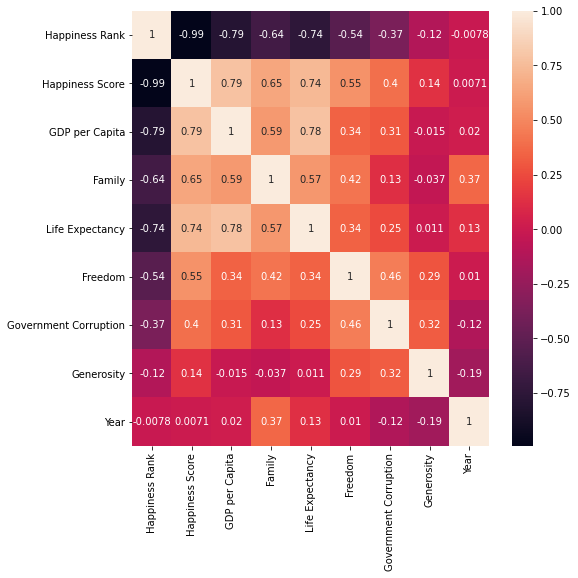

In [19]:
plt.figure(figsize=(8,8))
sns.heatmap(happiness.corr(), annot=True)

Happiness Rank and Happiness Score are inversely proportional, lower the Happiness Rank, higher will be the Happiness Score.

GDP per Capita, Family, Life Expectancy and Freedom are strongly (0.5) positively correlated with Happiness Score.
These features work together in a ripple effect, for example GDP per Capita correlates very strongly with Life Expectancy which in turn translates to a higher happiness score.

So, one factor cannot determine Happiness Score, they all work together.

Average Happiness in each year

In [20]:
happiness.groupby('Year')['Happiness Score'].mean()

Year
2015    5.375734
2016    5.382185
2017    5.354019
2018    5.375917
2019    5.407096
Name: Happiness Score, dtype: float64

Text(0.5, 1.0, 'Average World Happiness By Year')

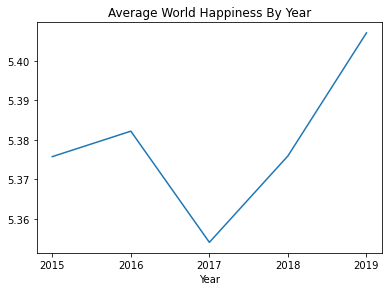

In [21]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

happiness.groupby('Year')['Happiness Score'].mean().plot()
ax.set_xticks([2015, 2016, 2017, 2018, 2019])
plt.title('Average World Happiness By Year')

World average happiness has increased overtime; there has been a steady climb in world happiness since the extreme deep in 2017. I would like to see what 2020 data looks like.

Average GDP per Capita in each year

In [22]:
happiness.groupby('Year')['GDP per Capita'].mean()

Year
2015    0.846137
2016    0.953880
2017    0.984718
2018    0.891449
2019    0.905147
Name: GDP per Capita, dtype: float64

Text(0.5, 1.0, 'Average GDP per Capita By Year')

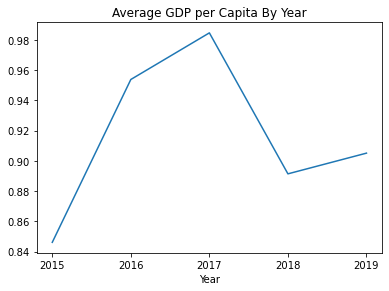

In [23]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

happiness.groupby('Year')['GDP per Capita'].mean().plot()
ax.set_xticks([2015, 2016, 2017, 2018, 2019])
plt.title('Average GDP per Capita By Year')

GDP's contribution to Happiness Score reached a peak in 2017 and then dropped in 2018 and started to go back up in 2019.

In [24]:
happiness.groupby('Year')['Family'].mean()

Year
2015    0.991046
2016    0.793621
2017    1.188898
2018    1.213237
2019    1.208814
Name: Family, dtype: float64

Text(0.5, 1.0, 'Average GDP per Capita By Year')

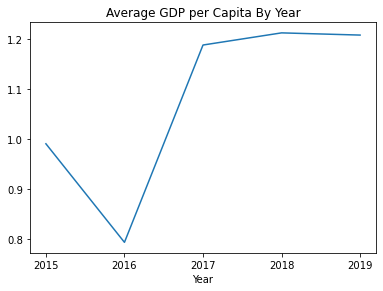

In [25]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

happiness.groupby('Year')['Family'].mean().plot()
ax.set_xticks([2015, 2016, 2017, 2018, 2019])
plt.title('Average GDP per Capita By Year')

Family Support was not very important to happiness score calculation in 2015 and especially 2016, but it's contribution has countined to increase since 2017.

Average Happiness Score by Country

In [26]:
country = happiness.groupby('Country')['Happiness Score'].mean()
country = pd.DataFrame(country)
country.reset_index(inplace=True)
country.head()

Country  Happiness Score
0  Afghanistan          3.51280
1      Albania          4.71260
2      Algeria          5.66760
3       Angola          3.87225
4    Argentina          6.45940

In [27]:
country.describe()

Happiness Score
count       170.000000
mean          5.380388
std           1.099061
min           3.079000
25%           4.466050
50%           5.334300
75%           6.163150
max           7.546000

The average happiness score of the world is 5.38; the happiest country has a happiness score of 7.546 and the least happy country has a happiness score of 3.079

**Happiest Countries**

In [28]:
country.sort_values(by='Happiness Score', ascending=False).head(10)

Country  Happiness Score
38       Denmark           7.5460
111       Norway           7.5410
46       Finland           7.5378
145  Switzerland           7.5114
61       Iceland           7.5110
103  Netherlands           7.4046
25        Canada           7.3506
144       Sweden           7.3192
104  New Zealand           7.3130
6      Australia           7.2762

**Saddest Countries**

In [29]:
country.sort_values(by='Happiness Score').head(10)

Country  Happiness Score
22                    Burundi          3.07900
26   Central African Republic          3.13425
146                     Syria          3.29220
138               South Sudan          3.38250
125                    Rwanda          3.43860
150                  Tanzania          3.46600
0                 Afghanistan          3.51280
152                      Togo          3.54420
167                     Yemen          3.62580
87                 Madagascar          3.74540

Most of the world's happiest countries are in Europe

Meanwhile the world's saddest countries are in Africa

**Nigeria's Happiness Score**

In [30]:
country[country['Country'] == 'Nigeria']

Country  Happiness Score
107  Nigeria           5.1274

Nigeria's happiness score is less than the average happiness score.

#### Choropleth map showing the happiness scores of countries

The shapefile used to get the coordinates of all the countries in the world was downloaded from [here](https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_0_countries.zip) 

In [31]:
shapefile = 'data/shapefile/ne_50m_admin_0_countries.shp'

#Read shapefile into pandas dataframe
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

#Rename columns
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head(10)

country country_code  \
0                        Zimbabwe          ZWE   
1                          Zambia          ZMB   
2                           Yemen          YEM   
3                         Vietnam          VNM   
4                       Venezuela          VEN   
5                         Vatican          VAT   
6                         Vanuatu          VUT   
7                      Uzbekistan          UZB   
8                         Uruguay          URY   
9  Federated States of Micronesia          FSM   

                                            geometry  
0  POLYGON ((31.28789 -22.40205, 31.19727 -22.344...  
1  POLYGON ((30.39609 -15.64307, 30.25068 -15.643...  
2  MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...  
3  MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...  
4  MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...  
5  POLYGON ((12.43916 41.89839, 12.43057 41.89756...  
6  MULTIPOLYGON (((166.74580 -14.82686, 166.81016...  
7  MULTIPOLYGON (((70.94678 42.24868, 70.97900 42...  
8  POLYGON ((-53.37061 -33.74219, -53.41958 -33.7...  
9  MULTIPOLYGON (((162.98320 5.32573, 162.99346 5...

Some countries *(like Trinidad & Tobago' AND 'Trinidad and Tobago)* are written differently in the *country* dataset and this resulted in duplicate values, I used the country converter library to get the country codes to eliminate the duplicates.

In [32]:
country['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Haiti', 'Honduras', 'Hong Kong',
       'Hong Kong S.A.R., China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'K

In [33]:
country['country_code'] = coco.convert(names=list(country['Country']), to='ISO3')

Merge the *geo data* with the *country* data on the country_code

In [34]:
merged=gdf.merge(country,left_on='country_code',right_on='country_code')
merged.head()

country country_code                                           geometry  \
0   Zimbabwe          ZWE  POLYGON ((31.28789 -22.40205, 31.19727 -22.344...   
1     Zambia          ZMB  POLYGON ((30.39609 -15.64307, 30.25068 -15.643...   
2      Yemen          YEM  MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...   
3    Vietnam          VNM  MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...   
4  Venezuela          VEN  MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...   

     Country  Happiness Score  
0   Zimbabwe           4.0066  
1     Zambia           4.5844  
2      Yemen           3.6258  
3    Vietnam           5.1546  
4  Venezuela           5.5314

Convert the merged data into a json file; the json file would be used for creating the map

In [35]:
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

In [36]:
#plot map
m = folium.Map(zoom_start=2)

folium.Choropleth(
    geo_data=json_data,
    name= 'Happiness Score',
    data= merged,
    columns=['country', 'Happiness Score'],
    key_on='feature.properties.Country',
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Happiness Score'
).add_to(m)
    
folium.LayerControl(collapsed=False).add_to(m)
m.save('map.html')
m

#### Relationship between Features and Happiness Score

<AxesSubplot:xlabel='GDP per Capita', ylabel='Happiness Score'>

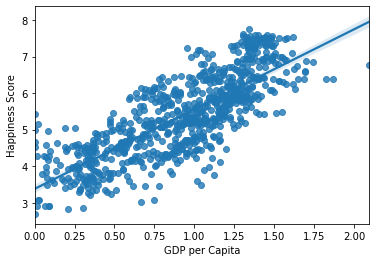

In [37]:
sns.regplot(x='GDP per Capita', y='Happiness Score', data=happiness)

Text(0, 0.5, 'Happiness score')

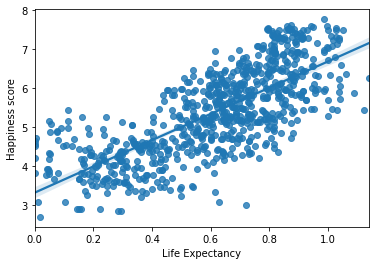

In [38]:
sns.regplot('Life Expectancy', 'Happiness Score', data=happiness)
plt.ylabel('Happiness score')

Text(0, 0.5, 'Happiness score')

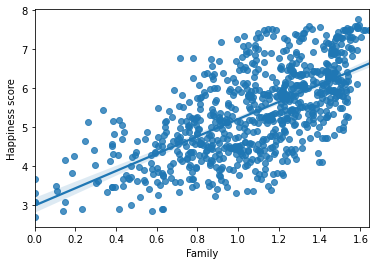

In [39]:
sns.regplot('Family', 'Happiness Score', data=happiness)
plt.ylabel('Happiness score')

<AxesSubplot:xlabel='Freedom', ylabel='Happiness Score'>

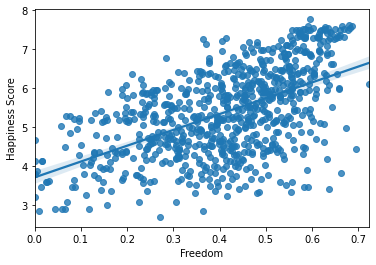

In [40]:
sns.regplot('Freedom', 'Happiness Score', data=happiness)

<AxesSubplot:xlabel='Government Corruption', ylabel='Happiness Score'>

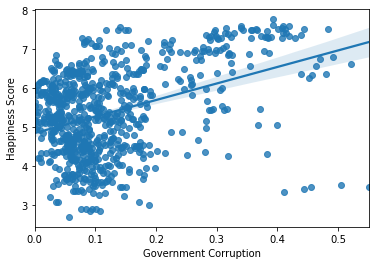

In [41]:
sns.regplot('Government Corruption', 'Happiness Score', data=happiness)

<AxesSubplot:xlabel='Generosity', ylabel='Happiness Score'>

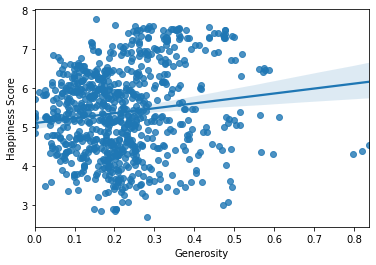

In [42]:
sns.regplot('Generosity', 'Happiness Score', data=happiness)

Looking at the regression plots above, all the features are directly proportional with Happiness Score but they definitely have different levels of fit with the regression line.

### Modelling

In [43]:
happiness.isnull().sum()

Country                  0
Happiness Rank           0
Happiness Score          0
GDP per Capita           0
Family                   0
Life Expectancy          0
Freedom                  0
Government Corruption    1
Generosity               0
Year                     0
dtype: int64

In [44]:
#fill the missing value
happiness['Government Corruption'].fillna(0, inplace=True)

In [45]:
happiness.shape

(782, 10)

#### Feature Scaling

In [46]:
scaler = StandardScaler()

In [47]:
scaled_data = scaler.fit_transform(happiness[['GDP per Capita', 'Family', 'Life Expectancy', 'Freedom',
       'Government Corruption', 'Generosity']])

happiness[['GDP per Capita', 'Family', 'Life Expectancy', 'Freedom',
       'Government Corruption', 'Generosity']] = scaled_data

#### Feature Selection

I separated the data into features and target variable and then split into train and test sets

I dropped 'Country' and 'Happiness Rank' from the feature set because they pose data leakage problem

In [48]:
x = happiness.drop(['Country', 'Happiness Rank', 'Happiness Score', 'Year'], axis=1)
y = happiness['Happiness Score']

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

In [50]:
x_train.shape

(625, 6)

In [51]:
x_test.shape

(157, 6)

#### Define Best Parameters by GridSearch

In [52]:
#hyperparameter dictionary
params = {RandomForestRegressor(): {'n_estimators': [100, 150, 200, 300],
                                     'max_depth': [None, 2, 4],
                                     "criterion": ["mse","mae"],
                                     'min_samples_split': [2, 3, 4, 5],
                                     'random_state': [5]
                                   }
         }

# initialization
best_score = 0 
best_param = None

#parameter search
for model, param in params.items():
    
    grid= GridSearchCV(model, param)
    grid.fit(x_train, y_train)
    score = grid.score(x_test, y_test)
    if best_score < score:
        best_score = score
        best_param = grid.best_params_
        
print(f"best parameters: {best_param}")
print(f"best score: {best_score}")

best parameters: {'criterion': 'mae', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 5}
best score: 0.8228699005982694


In [53]:
rand = RandomForestRegressor(criterion= 'mae', min_samples_split =2, n_estimators=150, random_state=10)

In [54]:
rand.fit(x_train, y_train)

RandomForestRegressor(criterion='mae', n_estimators=150, random_state=10)

In [55]:
print('MSE: ', mean_squared_error(y_test, rand.predict(x_test)))


MSE:  0.21378599680683852


In [56]:
print('RMSE: ', np.sqrt(mean_squared_error(y_test, rand.predict(x_test))))

RMSE:  0.4623699782715553


In [57]:
print('R2 Score: ', r2_score(y_test, rand.predict(x_test)))

R2 Score:  0.8265875818402617


### Feature Importance

In [58]:
importance = pd.DataFrame({'feat':x_test.columns, 
                          'coef': rand.feature_importances_})

importance.sort_values(by='coef', ascending=False)

feat      coef
0         GDP per Capita  0.306962
2        Life Expectancy  0.277632
3                Freedom  0.135873
1                 Family  0.101124
4  Government Corruption  0.091438
5             Generosity  0.086972

## Result

Random Forest Regressor gives an MSE of 0.2 and R2 Score of 82.65%; this was the best performing model when compared with Linear, Lasso and Ridge Regression models.

Taking a look at the feature importances all of the features contribute towards Happiness score and GDP per Capita and Life Expectancy contribute the most.